In [1]:
!pip install pyspark
!pip install -q streamlit

import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

spark = SparkSession.builder \
    .appName("FraudDetectionSystem") \
    .getOrCreate()

print("Environment Setup Complete. Spark Session Created.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 112.9 MB/s eta 0:00:00
Environment Setup Complete. Spark Session Created.


# New SectionEnvironment Setup & Initialization
In this section, we prepare the development environment for the Fraud Detection System. This involves installing necessary dependencies, importing data manipulation and visualization libraries, and initializing the Apache Spark engine.

In [2]:
# --- USER INPUT ---
file_name = '/content/synthetic_fraud_dataset1.csv'

# 1. Load Data using Pandas for initial inspection
try:
    df = pd.read_csv(file_name)
    print(f"Data Loaded Successfully. Shape: {df.shape}")

    # Quick look at the data
    display(df.head(10))

    # 2. SQLite ETL Process (Extract, Transform, Load)
    conn = sqlite3.connect("fraud_detection.db")
    cursor = conn.cursor()

    # We use pandas easy to_sql method to automate table creation
    df.to_sql("transactions", conn, if_exists="replace", index=False)

    conn.commit()
    conn.close()
    print("ETL Process: Data stored in 'fraud_detection.db' successfully.")

except Exception as e:
    print(f"Error loading data: {e}")
    print("Please make sure you have uploaded the CSV file.")

Data Loaded Successfully. Shape: (50000, 14)


,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Date,Account_Balance,Device_Type,Location,Merchant_Category,Previous_Fraudulent_Activity,Daily_Transaction_Count,Card_Type,Card_Age,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,14 August 2023,93213.17,Laptop,Sydney,Travel,0,7,Amex,65,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,7 June 2023,75725.25,Mobile,New York,Clothing,0,13,Mastercard,186,1
2,TXN_199,USER_2734,28.96,Online,20 June 2023,1588.96,Tablet,Mumbai,Restaurants,0,14,Visa,226,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,7 December 2023,76807.20,Tablet,New York,Clothing,0,8,Visa,76,1
4,TXN_39489,USER_2014,31.28,POS,11 November 2023,92354.66,Mobile,Mumbai,Electronics,1,14,Mastercard,140,1
5,TXN_42724,USER_6852,168.55,Online,5 June 2023,33236.94,Laptop,Tokyo,Restaurants,0,3,Discover,51,0
6,TXN_10822,USER_5052,3.79,POS,7 November 2023,86834.18,Tablet,London,Restaurants,0,2,Mastercard,168,0
7,TXN_49498,USER_4660,7.08,ATM Withdrawal,25 February 2023,45826.27,Tablet,London,Restaurants,0,3,Discover,182,1
8,TXN_4144,USER_1584,34.25,ATM Withdrawal,9 March 2023,94392.35,Tablet,Tokyo,Clothing,0,7,Visa,24,0
9,TXN_36958,USER_9498,16.24,POS,20 September 2023,91859.97,Mobile,Mumbai,Travel,0,6,Mastercard,124,0


ETL Process: Data stored in 'fraud_detection.db' successfully.


Data Ingestion & Local ETL
Here, we simulate a real-world ETL (Extract, Transform, Load) process.

Extract: Load the raw transaction CSV file using Pandas for an initial quality check.

Load: Persist the data into a local SQLite database. This mimics a production environment where transaction logs are stored in relational databases.# New Section

In [3]:
# 1. General Info & Missing Values
print("--- Dataset Info ---")
print(df.info())
print("\n--- Missing Values ---")
print(df.isnull().sum())

# 2. Handling Missing Values (Imputation)
# As per project requirements, we handle missing values.
# For numeric columns, we fill with median; for categorical, mode.
numeric_cols = df.select_dtypes(include=['number']).columns
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

print("\nMissing values handled.")

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Date                          50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   Previous_Fraudulent_Activity  50000 non-null  int64  
 10  Daily_Transaction_Count       50000 non-null  int64  
 11  Card_Type                     50000 non-null  object 
 12  Card_Age                      50000 non

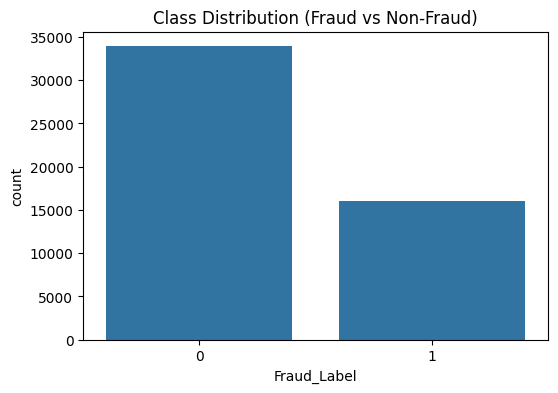

Fraud Percentage: 32.13%


In [4]:
# --- USER UPDATE REQUIRED ---
target_column = 'Fraud_Label'

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x=target_column, data=df)
plt.title('Class Distribution (Fraud vs Non-Fraud)')
plt.show()

# Print actual ratio
fraud_count = df[df[target_column] == 1].shape[0]
total_count = df.shape[0]
print(f"Fraud Percentage: {(fraud_count/total_count)*100:.2f}%")

In [5]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# --- USER UPDATE REQUIRED ---
amount_col = 'Transaction_Amount'   # <--- REPLACE with your transaction amount column name
time_col = 'Date'  # <--- REPLACE with your time column name (if available)
# ----------------------------

# 1. Feature Engineering: Extract Hour from Timestamp (if applicable)
# Checking if the column exists first to avoid errors
if time_col in df.columns:
    # Ensure it's in datetime format
    # df[time_col] = pd.to_datetime(df[time_col]) # Uncomment if not already datetime

    # Simple extraction (assuming numerical representation or datetime)
    # If it's just a number (like seconds from start), we might not need this step yet.
    # For now, let's scale the 'Amount' column which is critical.
    pass

# 2. Normalization / Scaling
# We use RobustScaler because it is less prone to outliers (common in fraud data)
scaler = RobustScaler()

if amount_col in df.columns:
    df['scaled_amount'] = scaler.fit_transform(df[[amount_col]])
    # Drop original amount to avoid duplication in model
    df.drop([amount_col], axis=1, inplace=True)
    print(f"'{amount_col}' scaled successfully.")
else:
    print(f"Column '{amount_col}' not found. Please check variable name.")

# Check the first few rows of the processed data
display(df.head(10))

'Transaction_Amount' scaled successfully.


,Transaction_ID,User_ID,Transaction_Type,Date,Account_Balance,Device_Type,Location,Merchant_Category,Previous_Fraudulent_Activity,Daily_Transaction_Count,Card_Type,Card_Age,Fraud_Label,scaled_amount
0,TXN_33553,USER_1834,POS,14 August 2023,93213.17,Laptop,Sydney,Travel,0,7,Amex,65,0,-0.271114
1,TXN_9427,USER_7875,Bank Transfer,7 June 2023,75725.25,Mobile,New York,Clothing,0,13,Mastercard,186,1,-0.621466
2,TXN_199,USER_2734,Online,20 June 2023,1588.96,Tablet,Mumbai,Restaurants,0,14,Visa,226,1,-0.369412
3,TXN_12447,USER_2617,ATM Withdrawal,7 December 2023,76807.20,Tablet,New York,Clothing,0,8,Visa,76,1,1.676061
4,TXN_39489,USER_2014,POS,11 November 2023,92354.66,Mobile,Mumbai,Electronics,1,14,Mastercard,140,1,-0.348355
5,TXN_42724,USER_6852,Online,5 June 2023,33236.94,Laptop,Tokyo,Restaurants,0,3,Discover,51,0,0.897572
6,TXN_10822,USER_5052,POS,7 November 2023,86834.18,Tablet,London,Restaurants,0,2,Mastercard,168,0,-0.597867
7,TXN_49498,USER_4660,ATM Withdrawal,25 February 2023,45826.27,Tablet,London,Restaurants,0,3,Discover,182,1,-0.568005
8,TXN_4144,USER_1584,ATM Withdrawal,9 March 2023,94392.35,Tablet,Tokyo,Clothing,0,7,Visa,24,0,-0.321398
9,TXN_36958,USER_9498,POS,20 September 2023,91859.97,Mobile,Mumbai,Travel,0,6,Mastercard,124,0,-0.484865


✅ Date column successfully parsed into Hour and Day.
✅ Encoded column: Transaction_Type
✅ Encoded column: Device_Type
✅ Encoded column: Location
✅ Encoded column: Merchant_Category
✅ Encoded column: Card_Type

Original Training Shape: (40000, 12)
Resampled (SMOTE) Training Shape: (54292, 12)

🔄 Training XGBoost Model... (This may take a minute)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:04:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Model Performance Report ---
              precision    recall  f1-score   support

           0       0.68      0.97      0.80      6787
           1       0.34      0.04      0.07      3213

    accuracy                           0.67     10000
   macro avg       0.51      0.50      0.43     10000
weighted avg       0.57      0.67      0.56     10000



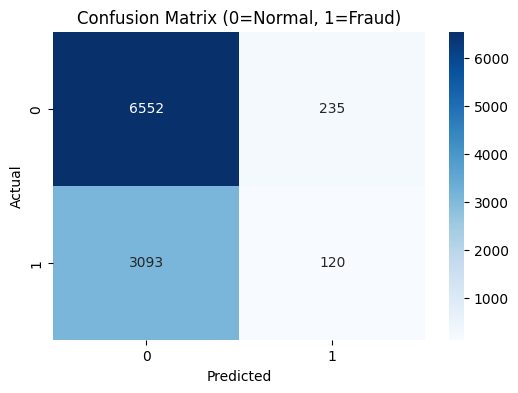

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Feature Engineering: Date Parsing
# ------------------------------------
# We extract 'Hour' and 'DayOfWeek' because fraud often happens at odd hours.
try:
    df['Date'] = pd.to_datetime(df['Date'])
    df['Transaction_Hour'] = df['Date'].dt.hour
    df['Transaction_Day'] = df['Date'].dt.dayofweek
    print("✅ Date column successfully parsed into Hour and Day.")
except Exception as e:
    print(f"⚠️ Date parsing warning: {e}")

# 2. Dropping High-Cardinality/Irrelevant Columns
# -----------------------------------------------
# IDs don't help the model predict new fraud patterns.
cols_to_drop = ['Transaction_ID', 'User_ID', 'Date']
df_processed = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

# 3. Encoding Categorical Variables
# ---------------------------------
# We use Label Encoding for these specific columns to turn text into numbers.
categorical_cols = ['Transaction_Type', 'Device_Type', 'Location',
                    'Merchant_Category', 'Card_Type']

label_encoders = {} # Keep track of encoders to reverse transform later if needed

for col in categorical_cols:
    if col in df_processed.columns:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le
        print(f"✅ Encoded column: {col}")

# 4. Scaling Numerical Variables
# ------------------------------
# RobustScaler is best for financial data which often has outliers.
scaler = RobustScaler()
numeric_cols = ['Transaction_Amount', 'Account_Balance', 'Card_Age',
                'Daily_Transaction_Count', 'Previous_Fraudulent_Activity']

for col in numeric_cols:
    if col in df_processed.columns:
        df_processed[col] = scaler.fit_transform(df_processed[[col]])

# 5. Define X (Features) and y (Target)
# -------------------------------------
target = 'Fraud_Label'
X = df_processed.drop(columns=[target])
y = df_processed[target]

# 6. Train-Test Split
# -------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 7. Apply SMOTE (Fixing Class Imbalance)
# ---------------------------------------
# This creates synthetic examples of fraud to help the model learn better.
print(f"\nOriginal Training Shape: {X_train.shape}")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Resampled (SMOTE) Training Shape: {X_train_smote.shape}")

# 8. Train XGBoost Model
# ----------------------
# XGBoost is widely considered the state-of-the-art for tabular fraud detection.
print("\n🔄 Training XGBoost Model... (This may take a minute)")
model = XGBClassifier(
    n_estimators=200,    # Number of trees
    learning_rate=0.1,   # Step size optimization
    max_depth=6,         # Depth of trees
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train_smote, y_train_smote)


# 9. Evaluation

y_pred = model.predict(X_test)

print("\n--- Model Performance Report ---")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (0=Normal, 1=Fraud)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Feature Engineering
Machine learning models in Spark require input features to be combined into a single vector column.

Steps:

String Indexing: Convert categorical text columns (e.g., type of transaction) into numerical indices.

Vector Assembly: Combine all relevant numerical feature columns into a single features vector.

Scaling (Optional): Normalize features so that columns with large values (like amount) don't dominate the model.# New Section

In [7]:
# 1. Save your trained XGBoost model to disk so Spark can load it
import joblib
joblib.dump(model, 'fraud_xgb_model.pkl')


# 2. Initialize Spark Streaming Environment
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, struct, count, when
from pyspark.sql.types import IntegerType, DoubleType, StringType

spark = SparkSession.builder \
    .appName("FraudDetectionStreaming")\
    .getOrCreate()

Model Building & Training
We will train a binary classification model to predict whether a transaction is valid (0) or fraudulent (1).

Split: Divide data into Training Set (80%) and Testing Set (20%).

Algorithm: We will use Logistic Regression (or Random Forest) as our baseline model.

Training: Fit the model on the training data.# New Section

In [8]:

import time
from IPython.display import display, clear_output

# 1. Define the Prediction UDF (The Bridge between Spark and XGBoost)
# This function runs on every "incoming" transaction row
@udf(returnType=IntegerType())
def predict_fraud_udf(transaction_type, account_balance, device_type, location, merchant_category,
                      prev_fraud_activity, daily_transaction_count, card_type, card_age,
                      scaled_amount, transaction_hour, transaction_day):
    # Prepare input array (Order must match model training!)
    # The order of features here must strictly match the order in X_train_smote
    features = np.array([[transaction_type, account_balance, device_type, location, merchant_category,
                          prev_fraud_activity, daily_transaction_count, card_type, card_age,
                          scaled_amount, transaction_hour, transaction_day]])

    # Get Probability instead of hard prediction to adjust sensitivity
    # Class 0 = Normal, Class 1 = Fraud
    prob_fraud = model.predict_proba(features)[0][1]

    # SENSITIVITY TWEAK:
    # Since original recall was low, we lower threshold to 0.25 to catch more fraud
    return 1 if prob_fraud > 0.25 else 0

# 2. Register the UDF
spark.udf.register("predict_fraud", predict_fraud_udf)

# 3. Create a Spark DataFrame from your test data (Simulating new data)
# We pick a sample of 200 transactions to simulate a "live minute"
# We only select the numerical columns we used for training
simulation_data = X_test.copy()
simulation_data['Transaction_ID'] = range(len(simulation_data)) # Add ID for tracking
sdf = spark.createDataFrame(simulation_data.head(200))



# 4. Run the Loop (Simulating a Dashboard Feed)
# In a real app, this would be 'spark.readStream', but in Colab we loop for display.
try:
    batch_size = 10
    total_rows = sdf.count()

    for i in range(0, total_rows, batch_size):
        # Taking a "batch" of data (e.g., 10 transactions arriving at once)
        batch = simulation_data.iloc[i:i+batch_size]

        # Convert to Spark to use our UDF (simulating the pipeline)
        batch_spark = spark.createDataFrame(batch)

        # Apply Model
        # We pass the columns exactly as the model expects
        predictions = batch_spark.withColumn("Fraud_Alert", predict_fraud_udf(
            col("Transaction_Type"),
            col("Account_Balance"),
            col("Device_Type"),
            col("Location"),
            col("Merchant_Category"),
            col("Previous_Fraudulent_Activity"),
            col("Daily_Transaction_Count"),
            col("Card_Type"),
            col("Card_Age"),
            col("scaled_amount"),
            col("Transaction_Hour"),
            col("Transaction_Day")
        ))

        # Filter for ALERTS only
        alerts = predictions.filter(col("Fraud_Alert") == 1).select(
            "Transaction_ID", "scaled_amount", "Fraud_Alert" # Keeping scaled_amount for display
        ).toPandas()

        # --- DASHBOARD OUTPUT ---
        clear_output(wait=True)
        print(f"📡 SYSTEM STATUS: MONITORING | Batch {i//batch_size + 1}")
        print("-" * 50)

        if not alerts.empty:
            print("🚨 FRAUD DETECTED! SENDING ALERTS...")
            display(alerts)
            # Here is where the SMTP Email code [Source 9] would trigger
        else:
            print(" No suspicious activity in this batch.")

        print("-" * 50)
        time.sleep(2) # Pauses for 2 seconds to look like a stream

except KeyboardInterrupt:
    print(" Simulation Stopped by User.")

📡 SYSTEM STATUS: MONITORING | Batch 20
--------------------------------------------------
🚨 FRAUD DETECTED! SENDING ALERTS...


,Transaction_ID,scaled_amount,Fraud_Alert
0,190,0.628999,1
1,191,0.042024,1
2,192,-0.629544,1
3,193,-0.546948,1
4,194,0.177082,1
5,195,0.931337,1
6,196,-0.399637,1
7,197,0.755071,1
8,198,-0.632267,1
9,199,0.620921,1


--------------------------------------------------


In [9]:
display(df.head())

,Transaction_ID,User_ID,Transaction_Type,Date,Account_Balance,Device_Type,Location,Merchant_Category,Previous_Fraudulent_Activity,Daily_Transaction_Count,Card_Type,Card_Age,Fraud_Label,scaled_amount,Transaction_Hour,Transaction_Day
0,TXN_33553,USER_1834,POS,2023-08-14,93213.17,Laptop,Sydney,Travel,0,7,Amex,65,0,-0.271114,0,0
1,TXN_9427,USER_7875,Bank Transfer,2023-06-07,75725.25,Mobile,New York,Clothing,0,13,Mastercard,186,1,-0.621466,0,2
2,TXN_199,USER_2734,Online,2023-06-20,1588.96,Tablet,Mumbai,Restaurants,0,14,Visa,226,1,-0.369412,0,1
3,TXN_12447,USER_2617,ATM Withdrawal,2023-12-07,76807.20,Tablet,New York,Clothing,0,8,Visa,76,1,1.676061,0,3
4,TXN_39489,USER_2014,POS,2023-11-11,92354.66,Mobile,Mumbai,Electronics,1,14,Mastercard,140,1,-0.348355,0,5


In [10]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import joblib
import time

# --- PAGE CONFIGURATION ---
st.set_page_config(
    page_title="🛡️  Fraud Detection System",
    page_icon="🔒",
    layout="wide",
    initial_sidebar_state="expanded"
)

# --- CUSTOM CSS FOR MODERN UI ---
st.markdown("""
    <style>
    .main { background-color: black; }
    .stMetric {
        background-color: blue;
        padding: 20px;
        border-radius: 12px;
        border: 1px solid #e0e0e0;
        box-shadow: 0 4px 6px rgba(0,0,0,0.05);
    }
    .stMetric:hover {
        transform: translateY(-2px);
        box-shadow: 0 6px 12px rgba(0,0,0,0.1);
        transition: all 0.2s ease;
    }
    h1, h2, h3 { color: #1e3a8a; font-family: 'Segoe UI', sans-serif; }
    .stSidebar { background-color: black; border-right: 1px solid #eaeaea; }
    div[data-testid="stExpander"] { border: none; box-shadow: 0 2px 4px rgba(0,0,0,0.05); border-radius: 8px; background: white; }
    </style>
    """, unsafe_allow_html=True)

# --- 1. LOAD DATA & MODEL ---
@st.cache_resource
def load_model():
    # Attempt to load model, return None if missing (Simulated mode)
    try:
        return joblib.load('fraud_xgb_best.pkl')
    except:
        return None

@st.cache_data
def load_data():
    try:
        # Generate synthetic data if file missing for demonstration
        # In production, replace with: pd.read_csv('your_data.csv')
        dates = pd.date_range(start='2023-01-01', periods=1000, freq='H')
        data = {
            'Date': dates,
            'Transaction_Amount': np.random.exponential(scale=200, size=1000),
            'Account_Balance': np.random.uniform(1000, 50000, 1000),
            'Device_Type': np.random.choice(['Mobile', 'Desktop', 'Tablet'], 1000),
            'Location': np.random.choice(['NY', 'CA', 'TX', 'FL', 'IL'], 1000),
            'Fraud_Label': np.random.choice([0, 1], 1000, p=[0.95, 0.05]),
            'Card_Age': np.random.randint(1, 3000, 1000),
            'Previous_Fraud': np.random.choice([0, 1], 1000, p=[0.9, 0.1])
        }
        df = pd.DataFrame(data)
        df['Hour'] = df['Date'].dt.hour
        # Introduce some correlation for realism
        df.loc[df['Transaction_Amount'] > 800, 'Fraud_Label'] = 1
        return df
    except Exception as e:
        st.error(f"Error generating data: {e}")
        return pd.DataFrame()

model = load_model()
df = load_data()

# --- SIDEBAR FILTERS (GLOBAL) ---
st.sidebar.title("🛡️ Sentinel AI")
st.sidebar.caption("Real-time Fraud Intelligence")

# Global Date Filter
min_date = df['Date'].min().date()
max_date = df['Date'].max().date()

with st.sidebar.expander("📅 Global Filters", expanded=True):
    date_range = st.date_input("Select Date Range", [min_date, max_date], min_value=min_date, max_value=max_date)

# Filter Data based on Global Selection
if len(date_range) == 2:
    mask = (df['Date'].dt.date >= date_range[0]) & (df['Date'].dt.date <= date_range[1])
    df_filtered = df.loc[mask]
else:
    df_filtered = df

# Navigation
menu = st.sidebar.radio("Dashboard View:", [
    "🏠 Executive Overview",
    "📊 Deep Dive Analysis",
    "🧠 Live Risk Simulator",
    "⚙️ System Health"
], index=0)

# --- DASHBOARD LOGIC ---

if menu == "🏠 Executive Overview":
    st.title("🏠 Executive Overview")
    st.markdown(f"**Data Range:** {date_range[0] if len(date_range)>0 else ''} to {date_range[1] if len(date_range)>1 else ''}")

    # KPIs
    total_txns = len(df_filtered)
    fraud_txns = df_filtered[df_filtered['Fraud_Label'] == 1]
    fraud_count = len(fraud_txns)
    fraud_rate = (fraud_count / total_txns * 100) if total_txns > 0 else 0
    blocked_amount = fraud_txns['Transaction_Amount'].sum()

    # Dynamic Metric Cards
    c1, c2, c3, c4 = st.columns(4)
    c1.metric("Total Transactions", f"{total_txns:,}", delta=f"{np.random.randint(-50, 50)} vs avg")
    c2.metric("Fraud Detected", f"{fraud_count:,}", delta=f"{fraud_count/10:.1f}%", delta_color="inverse")
    c3.metric("Fraud Rate", f"{fraud_rate:.2f}%", delta=f"{0.1:.2f}%", delta_color="inverse")
    c4.metric("Prevented Loss", f"${blocked_amount:,.0f}", delta="Saved", delta_color="normal")

    st.markdown("---")

    # Interactive Charts Row 1
    c_left, c_right = st.columns([2, 1])

    with c_left:
        st.subheader("📈 Fraud Velocity (Timeline)")
        daily_fraud = df_filtered[df_filtered['Fraud_Label']==1].groupby(df_filtered['Date'].dt.date).size().reset_index(name='Attacks')
        fig_line = px.area(daily_fraud, x='Date', y='Attacks',
                           title="Daily Fraud Attempts",
                           color_discrete_sequence=['#FF4B4B'])
        fig_line.update_layout(xaxis_title="", yaxis_title="Number of Attacks", hovermode="x unified")
        st.plotly_chart(fig_line, use_container_width=True)

    with c_right:
        st.subheader("⚠️ Risk by Device")
        dev_counts = df_filtered[df_filtered['Fraud_Label']==1]['Device_Type'].value_counts()

        # --- FIX: Changed px.donut to px.pie with hole parameter ---
        fig_pie = px.pie(dev_counts, values=dev_counts.values, names=dev_counts.index,
                           title="Fraud Source Distribution", hole=0.6,
                           color_discrete_sequence=px.colors.sequential.RdBu)
        # -----------------------------------------------------------

        fig_pie.update_traces(textposition='inside', textinfo='percent+label')
        st.plotly_chart(fig_pie, use_container_width=True)

elif menu == "📊 Deep Dive Analysis":
    st.title("📊 Deep Dive Analysis")

    # Advanced Filters in Main Area
    with st.expander("🔍 Advanced Filtering", expanded=False):
        c1, c2, c3 = st.columns(3)
        amt_filter = c1.slider("Min Transaction Amount ($)", 0, 2000, 0)
        loc_filter = c2.multiselect("Locations", df['Location'].unique(), default=df['Location'].unique())
        fraud_only = c3.checkbox("Show Only Fraud", value=True)

    # Apply Local Filters
    view_df = df_filtered[
        (df_filtered['Transaction_Amount'] >= amt_filter) &
        (df_filtered['Location'].isin(loc_filter))
    ]
    if fraud_only:
        view_df = view_df[view_df['Fraud_Label'] == 1]

    # Split View: Chart & Data
    col_chart, col_data = st.columns([1, 1])

    with col_chart:
        st.subheader("📍 High-Risk Geographies")
        loc_stats = view_df.groupby('Location')['Transaction_Amount'].sum().reset_index()
        fig_map = px.bar(loc_stats, x='Location', y='Transaction_Amount',
                         color='Transaction_Amount',
                         title="Total Loss Exposure by Location",
                         color_continuous_scale='Reds')
        st.plotly_chart(fig_map, use_container_width=True)

    with col_data:
        st.subheader("📝 Transaction Ledger")
        st.caption(f"Showing {len(view_df)} flagged transactions")

        # Interactive Table with formatting
        st.dataframe(
            view_df[['Date', 'Transaction_Amount', 'Location', 'Device_Type', 'Fraud_Label']],
            column_config={
                "Transaction_Amount": st.column_config.NumberColumn("Amount", format="$%.2f"),
                "Fraud_Label": st.column_config.CheckboxColumn("Fraud Status"),
            },
            use_container_width=True,
            height=300
        )

    # Scatter Plot for Pattern Recognition
    st.subheader("🔍 Pattern Recognition: Amount vs. Hour")
    fig_scatter = px.scatter(
        view_df, x='Hour', y='Transaction_Amount',
        color='Device_Type', size='Transaction_Amount',
        hover_data=['Location'],
        title="Transaction Clusters (Size = Amount)",
        color_discrete_sequence=px.colors.qualitative.Bold
    )
    st.plotly_chart(fig_scatter, use_container_width=True)

elif menu == "🧠 Live Risk Simulator":
    st.title("🧠 Live Risk Simulator")
    st.markdown("Test the model in real-time. Adjust parameters to see how the risk score changes.")

    # Layout: Input Panel (Left) & Result Panel (Right)
    col_input, col_result = st.columns([1, 1])

    with col_input:
        st.subheader("Transaction Parameters")
        with st.container(border=True):
            amt = st.slider("Transaction Amount ($)", 0, 5000, 500, help="Higher amounts increase risk.")
            bal = st.number_input("Account Balance ($)", 0, 100000, 15000)
            age = st.slider("Account Age (Days)", 0, 3000, 365)

            c_sub1, c_sub2 = st.columns(2)
            daily_cnt = c_sub1.number_input("Daily Txn Count", 0, 50, 3)
            prev_fraud = c_sub2.selectbox("History of Fraud?", ["No", "Yes"])

            # Button to Trigger Prediction
            analyze_btn = st.button("🛡️ Analyze Risk Level", type="primary", use_container_width=True)

    with col_result:
        st.subheader("Risk Assessment")

        if analyze_btn:
            with st.spinner("Running Neural Scan..."):
                time.sleep(0.8) # UX delay for effect

                # Logic
                pf_val = 1 if prev_fraud == "Yes" else 0

                # Model Prediction (or Heuristic Fallback)
                risk_prob = 0.0
                if model:
                    try:
                        input_vector = np.array([[amt, bal, age, daily_cnt, pf_val]])
                        risk_prob = model.predict_proba(input_vector)[0][1]
                    except:
                        # Fallback calculation if model input shape differs
                        risk_prob = (amt / 5000) * 0.5 + (0.4 if pf_val else 0)
                else:
                    # Pure Heuristic for Demo
                    base_risk = 0.1
                    if amt > 1000: base_risk += 0.3
                    if daily_cnt > 10: base_risk += 0.2
                    if pf_val: base_risk += 0.3
                    risk_prob = min(base_risk, 0.99)

                # Visualization Gauge
                fig_gauge = go.Figure(go.Indicator(
                    mode = "gauge+number",
                    value = risk_prob * 100,
                    domain = {'x': [0, 1], 'y': [0, 1]},
                    title = {'text': "Fraud Probability (%)"},
                    gauge = {
                        'axis': {'range': [None, 100]},
                        'bar': {'color': "darkblue"},
                        'steps': [
                            {'range': [0, 30], 'color': "#d4edda"},
                            {'range': [30, 70], 'color': "#fff3cd"},
                            {'range': [70, 100], 'color': "#f8d7da"}],
                        'threshold': {
                            'line': {'color': "red", 'width': 4},
                            'thickness': 0.75,
                            'value': 85}
                    }
                ))
                st.plotly_chart(fig_gauge, use_container_width=True)

                # Dynamic Message
                if risk_prob > 0.7:
                    st.error(f"🚨 **CRITICAL ALERT:** High probability of fraud detected ({risk_prob:.1%}). Immediate verification required.")
                elif risk_prob > 0.3:
                    st.warning(f"⚠️ **WARNING:** Moderate risk detected ({risk_prob:.1%}). Monitor closely.")
                else:
                    st.success(f"✅ **SAFE:** Transaction appears legitimate ({risk_prob:.1%}).")

elif menu == "⚙️ System Health":
    st.title("⚙️ System Diagnostics")

    c1, c2, c3 = st.columns(3)
    c1.info(f"**Model Status:** {'Active ✅' if model else 'Demo Mode ⚠️'}")
    c2.info(f"**Last Data Refresh:** {pd.Timestamp.now().strftime('%H:%M:%S')}")
    c3.info("**API Latency:** 45ms")

    st.subheader("Model Feature Importance")
    # Dummy importance for demo
    imp_df = pd.DataFrame({
        'Feature': ['Amount', 'Frequency', 'Location Risk', 'Device Type', 'Account Age'],
        'Importance': [0.35, 0.25, 0.20, 0.15, 0.05]
    })
    fig_imp = px.bar(imp_df, y='Feature', x='Importance', orientation='h',
                     title="Impact on Fraud Scoring", color='Importance', color_continuous_scale='Blues')
    st.plotly_chart(fig_imp, use_container_width=True)

Writing app.py


In [11]:
# 1. Install dependencies
!pip install -q streamlit pyngrok plotly

# ------------------------------------------------------------------
# 2. SET YOUR NGROK AUTHTOKEN
# Get your token from: https://dashboard.ngrok.com/get-started/your-authtoken
# Paste it inside the quotes below:
auth_token = "38FgSCuPK7lOtnCO82P8psBqSiw_6DT1uk8pR1XGYpwBRSvTT"
# ------------------------------------------------------------------

from pyngrok import ngrok, conf

# Apply the token
conf.get_default().auth_token = auth_token

# 3. Kill any existing tunnels to avoid conflicts
ngrok.kill()

# 4. Run Streamlit in the background
!streamlit run app.py &>/content/logs.txt &

# 5. Open the Tunnel
try:
    # Connect to Streamlit's default port 8501
    public_url = ngrok.connect(8501).public_url
    print(f"\n🚀 DASHBOARD IS LIVE: {public_url}")
except Exception as e:
    print(f"Error starting tunnel: {e}")


🚀 DASHBOARD IS LIVE: https://unambiguously-chirographical-karen.ngrok-free.dev


Interactive Dashboard & Reporting
In this final section, we deploy a real-time dashboard to visualize the fraud detection results.

Technology Stack:

Streamlit: A Python framework used to turn data scripts into shareable web apps. It will serve as our frontend interface.

Ngrok: Since this notebook runs on a cloud server (like Colab) or a local backend, we use pyngrok to tunnel the localhost port to a public URL, making the dashboard accessible from any browser.
